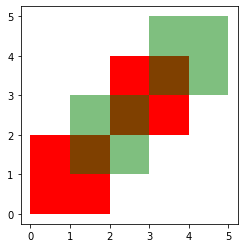

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
#intersection between two polygons
polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),Polygon([(2,2), (4,2), (4,4), (2,4)])])
polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),Polygon([(3,3), (5,3), (5,5), (3,5)])])
df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})
df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})
ax = df1.plot(color='red');
df2.plot(ax=ax, color='green', alpha=0.5);
plt.show()

In [3]:
def CreateHexGrid(area, xleft, ybottom, xright, ytop, savename):
    #error checks
    if area <0:
        raise MarxanServicesError("Area value is invalid")
        
    if len(savename) <= 0:
        return "No output filename given"
    
    if (xleft >= xright):
        return "Invalid extent width: " + unicode(xleft) + " - " + unicode(xright)
    
    if (ybottom >= ytop):
        return "Invalid extent height: " + unicode(ybottom) + " - " + unicode(ytop)
        
    #calculate the spacing between the hexagons to give you the required area
    sideLength = math.sqrt((2*area)/(3*math.sqrt(3)))
    xspacing = sideLength + (sideLength * 0.5) # the cos(60) = 0.5
    yspacing = xspacing / 0.866025
    print "area: " + str(area) 
    print "minx: " + str(xleft)
    print "miny: " + str(ybottom)
    print "maxx: " + str(xright)
    print "maxy: " + str(ytop)
    print "sideLength: " + str(sideLength)
    print "xspacing: " + str(xspacing)
    print "yspacing: " + str(yspacing)

    #create a new geodataframe to store the hexagons
    newdata = gpd.GeoDataFrame()
    newdata.crs = {'init' :'epsg:3410'}
       
    #create the geometry field and an id field
    newdata['geometry'] = None
    newdata['id'] = None
    
    #get the number of rows/columns
    rows = int(ceil((ytop - ybottom) / yspacing))
    columns = int(ceil((xright - xleft) / xspacing))
    print "rows, columns: " + str(rows) + " " + str( columns)
    
    #initialise the feature counter
    feature_count = 0
    
    #THE FOLLOWING CODE COMES FROM MICHAEL MINN'S MMQGIS PLUGIN - http://michaelminn.com/linux/mmqgis/
    
    # To preserve symmetry, hspacing is fixed relative to vspacing
    xvertexlo = 0.288675134594813 * yspacing
    xvertexhi = 0.577350269189626 * yspacing
    xspacing = xvertexlo + xvertexhi

    for column in range(0, int(floor(float(xright - xleft) / xspacing))):
        # (column + 1) and (row + 1) calculation is used to maintain 
        # topology between adjacent shapes and avoid overlaps/holes 
        # due to rounding errors

        x1 = xleft + (column * xspacing)    # far left
        x2 = x1 + (xvertexhi - xvertexlo)    # left
        x3 = xleft + ((column + 1) * xspacing)    # right
        x4 = x3 + (xvertexhi - xvertexlo)    # far right

        for row in range(0, int(floor(float(ytop - ybottom) / yspacing))):

            if (column % 2) == 0:
                y1 = ybottom + (((row * 2) + 0) * (yspacing / 2))    # hi
                y2 = ybottom + (((row * 2) + 1) * (yspacing / 2))    # mid
                y3 = ybottom + (((row * 2) + 2) * (yspacing / 2))    # lo
            else:
                y1 = ybottom + (((row * 2) + 1) * (yspacing / 2))    # hi
                y2 = ybottom + (((row * 2) + 2) * (yspacing / 2))    # mid
                y3 = ybottom + (((row * 2) + 3) * (yspacing / 2))    #lo

            #create the coordinates of the hexagon
            coordinates = [(x1, y2), (x2, y1), (x3, y1), (x4, y2), (x3, y3), (x2, y3), (x1, y2)]
            
            #cretae a polygon with the coordinates
            poly = Polygon(coordinates)

            #set the geometry
            newdata.loc[feature_count, 'geometry'] = poly

            #set the feature id
            newdata.loc[feature_count, 'id'] = feature_count
            
            #increment the counter
            feature_count = feature_count + 1
            break
        break

    # Write the data into that Shapefile
    newdata.to_file("E:/cottaan/Documents/ArcGIS/Datasets/" + savename + ".shp")
    
    # Write the prj file as it doesnt get produced
    file = open("E:/cottaan/Documents/ArcGIS/Datasets/" + savename + ".prj","w") 
    file.write('PROJCS["NSIDC_EASE_Grid_Global",GEOGCS["GCS_Unspecified datum based upon the International 1924 Authalic Sphere",DATUM["D_Sphere_International_1924_Authalic",SPHEROID["International_1924_Authalic_Sphere",6371228,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",30],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]') 
    file.close()
    
    return "Hexagon grid created"

SyntaxError: invalid syntax (<ipython-input-3-6d214ee78ceb>, line 19)

In [4]:
import math, fiona
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from math import floor, ceil

#get the global administrative boundaries
world = gpd.read_file(r'E:\cottaan\Documents\ArcGIS\Datasets\gaul_eez\jrc_gaul_2015_eez_v9_dissolved_from_andreas_spatial_lite_db.shp')

#get the country boundary
png = world.loc[world['iso3']=='PNG']
# eastern_highlands = gpd.read_file(r'E:\cottaan\Documents\ArcGIS\eastern_highlands.shp')
print type(png['geometry'])

#reproject and get the bounds
bounds = png['geometry'].to_crs(epsg=3410).bounds.iloc[0] #iloc gets the first bounds

#create the hexagon grid
CreateHexGrid(50000000, bounds.minx,  bounds.miny, bounds.maxx, bounds.maxy,'test8')

#get the hexagon grid
hexGrid = gpd.read_file(r'E:\cottaan\Documents\ArcGIS\Datasets\test8.shp')

#do the intersection between the country boundary and the hexagon grid and write the results
# intersection = gpd.overlay(png, hexGrid, how='intersection')
# intersection.to_file("E:/cottaan/Documents/ArcGIS/Datasets/intersection.shp")

# plt.clf()
# png.plot()
# eastern_highlands.plot()
# intersection.plot()
# plt.show()


DriverError: E:\cottaan\Documents\ArcGIS\Datasets\gaul_eez\jrc_gaul_2015_eez_v9_dissolved_from_andreas_spatial_lite_db.shp: No such file or directory

In [5]:
import geopandas as gpd
hexGrid = gpd.read_file(r"E:\cottaan\Documents\ArcGIS\test_hexagon3.shp")
png = gpd.read_file(r"E:\cottaan\Documents\ArcGIS\Datasets\gaul_eez\gaul_2015_simplified.shp")
intersection = gpd.overlay(png, hexGrid, how='intersection')
# intersection.to_file("E:/cottaan/Documents/ArcGIS/Datasets/intersection.shp")

DriverError: E:\cottaan\Documents\ArcGIS\test_hexagon3.shp: No such file or directory

In [ ]:
world =  gpd.read_file(r"E:\cottaan\Documents\ArcGIS\Datasets\gaul_eez\gaul_2015_simplified.shp")
png = world.loc[world['iso3']=='PNG']
print dir(png['geometry'])
bounds = png['geometry'].to_crs(epsg=3410).bounds.iloc[0] #iloc gets the first bounds
print bounds

In [ ]:
import fiona
from geopandas import GeoSeries
from shapely.geometry import shape
from shapely.wkt import loads
world = fiona.open(r"E:\cottaan\Documents\ArcGIS\Datasets\gaul_eez\gaul_2015_simplified.shp")
filtered = filter(lambda f: f['properties']['iso3']=='PNG', world)[0]
print shape(filtered['geometry'])